# IN PROGRESS!

Copyright (C) 2020 OERCompBiomed   

# K-means clustring of MRI data set from the TCGA-GBM data collection 

## The TCGA-GBM data collection

https://wiki.cancerimagingarchive.net/display/Public/TCGA-GBM

The **Cancer Genome Atlas Glioblastoma Multiforme** (TCGA-GBM) data collection is part of a larger effort to build a research community focused on connecting cancer phenotypes to genotypes by providing clinical images matched to subjects from The Cancer Genome Atlas ([TCGA](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)). 

Clinical, genetic, and pathological data resides in the [Genomic Data Commons (GDC) Data Portal](https://portal.gdc.cancer.gov/exploration?filters=%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.project.program.name%22%2C%22value%22%3A%5B%22TCGA%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.project.project_id%22%2C%22value%22%3A%5B%22TCGA-GBM%22%5D%7D%7D%5D%7D) while the radiological data is stored on The Cancer Imaging Archive ([TCIA](https://www.cancerimagingarchive.net)). 
Matched TCGA patient identifiers allow researchers to explore the TCGA/TCIA databases for correlations between tissue genotype, radiological phenotype and patient outcomes.  

Tissues for TCGA were collected from many sites all over the world in order to reach their accrual targets, usually around 500 specimens per cancer type.  For this reason the image data sets are also extremely heterogeneous in terms of scanner modalities, manufacturers and acquisition protocols.  In most cases the images were acquired as part of routine care and not as part of a controlled research study or clinical trial. 

#### CIP TCGA Radiology Initiative

Imaging Source Site (ISS) Groups are being populated and governed by participants from institutions that have provided imaging data to the archive for a given cancer type. Modeled after TCGA analysis groups, ISS groups are given the opportunity to publish a marker paper for a given cancer type per the guidelines in the table above. This opportunity will generate increased participation in building these multi-institutional data sets as they become an open community resource.  Learn more about the [TCGA Glioma Phenotype Research Group](https://wiki.cancerimagingarchive.net/display/Public/TCGA+Glioma+Phenotype+Research+Group).

### Citations & Data Useage Policy

Citations & Data Usage Policy 
Users of this data must abide by the [Creative Commons Attribution 3.0 Unported License](https://creativecommons.org/licenses/by/3.0) under which it has been published. Attribution should include references to the following citations:

**TCGA Attribution**

"The results [published or shown] here are in whole or part based upon data generated by the TCGA Research Network: http://cancergenome.nih.gov."

**Data Citation**

Scarpace, L., Mikkelsen, T., Cha, soonmee, Rao, S., Tekchandani, S., Gutman, D., … Pierce, L. J. (2016). Radiology Data from The Cancer Genome Atlas Glioblastoma Multiforme [TCGA-GBM] collection. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2016.RNYFUYE9


**TCIA Citation**

Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. *The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository*, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057. (paper DOI:10.1007/s10278-013-9622-7) [[link](https://link.springer.com/article/10.1007/s10278-013-9622-7)]

## The data set we will be using

We will be using a four-channel multispectral image (an axial slice from a multispectral 3D recording is shown below),  <br>
downloded from the TCGA-GBM data collection - i.e. study TCGA-06-1802.
The DICOM images were converted to NIFTI using the [dcm2niix](https://github.com/rordenlab/dcm2niix) software. 

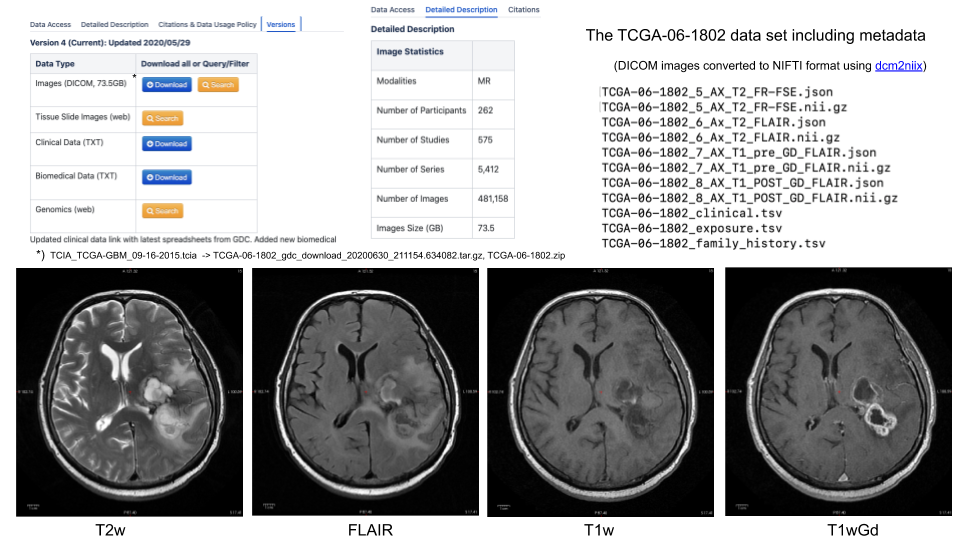

In [1]:
from IPython.display import Image
Image(filename='./assets/TCGA-GBM-dataset.png', width=900)

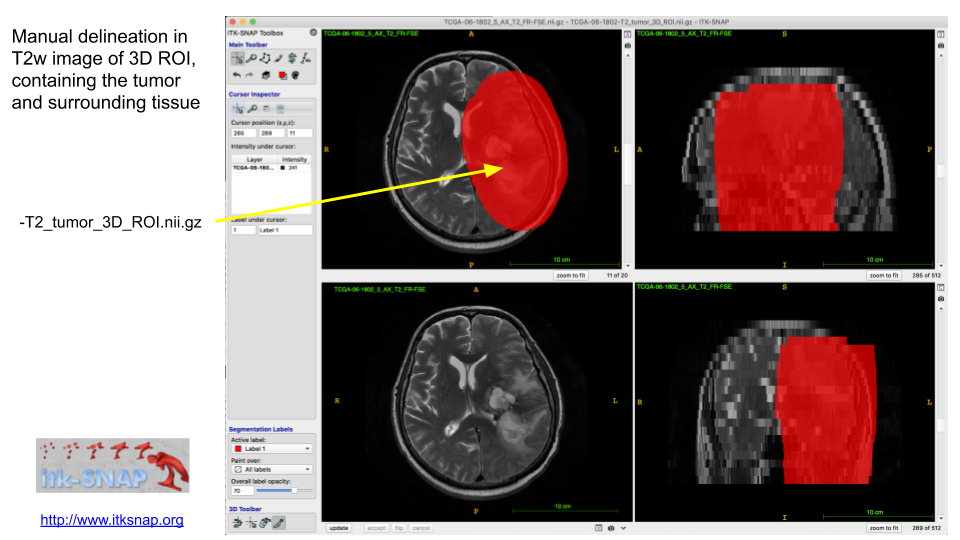

In [2]:
from IPython.display import Image
Image(filename='./assets/TCGA-GBM-dataset-3D-ROI.png', width=900)

**Import libraries to be used**

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
#import joblib
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython
home = os.path.expanduser('~')  # To make path to local home directory

**Define the channel names (MRI pulse sequence acronyms)**

In [4]:
chn_names = ['T2', 'FLAIR', 'T1', 'T1Gd']

## Read the multispectral MR image and the binary ROI mask

In [5]:
# Using nibabel to read the multispectral image (and the ROI mask)
base = './data/TCGA-06-1802/TCGA-06-1802'
fn_t2 = '%s_5_AX_T2_FR-FSE.nii.gz' % base
fn_flair = '%s_6_Ax_T2_FLAIR.nii.gz' % base
fn_t1 = '%s_7_AX_T1_pre_GD_FLAIR.nii.gz' % base
fn_t1gd = '%s_8_AX_T1_POST_GD_FLAIR.nii.gz' % base
fn_roi = '%s-T2_tumor_3D_ROI.nii.gz' % base

def load_chn(chn):
    img = nib.load(chn)
    return img

img_t2 = load_chn(fn_t2)
img_flair = load_chn(fn_flair)
img_t1 = load_chn(fn_t1)
img_t1gd = load_chn(fn_t1gd)
img_roi = load_chn(fn_roi)

**Print properties of the multispectral NIFTI image**

In [6]:
def img_prop(img, chn):
    print('**Channel image info %s:**' % (chn))
    print('shape of image = ', img.header.get_data_shape())
    print('voxel size = ', img.header.get_zooms())
    print('dtype = %s' % img.header.get_data_dtype())
    dat = img.get_fdata()
    print('min = %.1f' % dat.min())
    print('max = %.1f' % dat.max())
    print('number of slices =', img.shape[-1])
    # Collaps the singular (z-)dimension
    data = np.uint16(dat.squeeze())
    print('shape of data = ',data.shape)
    print('dtype of data = ',data.dtype)
    print('img affine:', img.affine)
    print('\n')
    
img_prop(img_t2, chn_names[0])
img_prop(img_flair, chn_names[1])
img_prop(img_t1, chn_names[2])
img_prop(img_t1gd, chn_names[3])

**Channel image info T2:**
shape of image =  (512, 512, 20)
voxel size =  (0.4297, 0.4297, 7.499882)
dtype = int16
min = 0.0
max = 1774.0
number of slices = 20
shape of data =  (512, 512, 20)
dtype of data =  uint16
img affine: [[-4.29655105e-01  4.23577521e-03 -7.92268217e-02  1.10343521e+02]
 [ 5.33721503e-03  4.12535071e-01 -2.09651637e+00 -6.90474243e+01]
 [-3.17350053e-03  1.20162129e-01  7.20045614e+00 -8.45515442e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Channel image info FLAIR:**
shape of image =  (512, 512, 25)
voxel size =  (0.4297, 0.4297, 5.9998765)
dtype = int16
min = 0.0
max = 1299.0
number of slices = 25
shape of data =  (512, 512, 25)
dtype of data =  uint16
img affine: [[-4.29655105e-01  4.23577521e-03 -6.33811504e-02  1.10350517e+02]
 [ 5.33721503e-03  4.12535071e-01 -1.67720497e+00 -6.88374176e+01]
 [-3.17350053e-03  1.20162129e-01  5.76033688e+00 -8.52715454e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**PROBLEM: The 4 recordings have different number of slices and different slice thicknesses (the in-plane matrices and resolutions are the same)**

We do (behind the scene), using [FreeSurfer](https://surfer.nmr.mgh.harvard.edu)'s [`mri_convert`](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_convert), coregistration of all channels to the T2 recording (which has also been used as the template for manual 3D ROI delineation of the tumor region and surroundings)

```
mri_convert TCGA-06-1802_6_Ax_T2_FLAIR.nii.gz TCGA-06-1802_6_Ax_T2_FLAIR_to_T2.nii.gz --like TCGA-06-1802_5_AX_T2_FR-FSE.nii.gz

mri_convert TCGA-06-1802_7_AX_T1_pre_GD_FLAIR.nii.gz TCGA-06-1802_7_AX_T1_pre_GD_FLAIR_to_T2.nii.gz --like TCGA-06-1802_5_AX_T2_FR-FSE.nii.gz

mri_convert TCGA-06-1802_8_AX_T1_POST_GD_FLAIR.nii.gz TCGA-06-1802_8_AX_T1_POST_GD_FLAIR_to_T2.nii.gz  --like TCGA-06-1802_5_AX_T2_FR-FSE.nii.gz
```

**Using the coregistred channel images to construct a multispectral image**

In [7]:
fn_flair_to_t2 = '%s_6_Ax_T2_FLAIR_to_T2.nii.gz' % base
fn_t1_to_t2 = '%s_7_AX_T1_pre_GD_FLAIR_to_T2.nii.gz' % base
fn_t1gd_to_t2 = '%s_8_AX_T1_POST_GD_FLAIR_to_T2.nii.gz' % base

img_flair_to_t2 = load_chn(fn_flair_to_t2)
img_t1_to_t2 = load_chn(fn_t1_to_t2)
img_t1gd_to_t2 = load_chn(fn_t1gd_to_t2)

Checking for geomtric alignment:

In [8]:
img_prop(img_t2, chn_names[0])
img_prop(img_flair_to_t2, chn_names[1])
img_prop(img_t1_to_t2, chn_names[2])
img_prop(img_t1gd_to_t2, chn_names[3])

**Channel image info T2:**
shape of image =  (512, 512, 20)
voxel size =  (0.4297, 0.4297, 7.499882)
dtype = int16
min = 0.0
max = 1774.0
number of slices = 20
shape of data =  (512, 512, 20)
dtype of data =  uint16
img affine: [[-4.29655105e-01  4.23577521e-03 -7.92268217e-02  1.10343521e+02]
 [ 5.33721503e-03  4.12535071e-01 -2.09651637e+00 -6.90474243e+01]
 [-3.17350053e-03  1.20162129e-01  7.20045614e+00 -8.45515442e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Channel image info FLAIR:**
shape of image =  (512, 512, 20)
voxel size =  (0.4297, 0.4297, 7.499882)
dtype = int16
min = 0.0
max = 1217.0
number of slices = 20
shape of data =  (512, 512, 20)
dtype of data =  uint16
img affine: [[-4.29655105e-01  4.23577521e-03 -7.92268217e-02  1.10343521e+02]
 [ 5.33721503e-03  4.12535071e-01 -2.09651637e+00 -6.90474243e+01]
 [-3.17350077e-03  1.20162129e-01  7.20045662e+00 -8.45515442e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



**Concatenate the cannel images to one multispectral image using [`nilearn.image.concat_imgs`](https://nilearn.github.io/modules/generated/nilearn.image.concat_imgs.html)**

In [9]:
images = [img_t2, img_flair_to_t2, img_t1_to_t2, img_t1gd_to_t2]
img_mult = image.concat_imgs(images)
img_prop(img_mult, 'multispectral')

**Channel image info multispectral:**
shape of image =  (512, 512, 20, 4)
voxel size =  (0.4297, 0.4297, 7.499882, 3.4)
dtype = int16
min = 0.0
max = 2147.0
number of slices = 4
shape of data =  (512, 512, 20, 4)
dtype of data =  uint16
img affine: [[-4.29655105e-01  4.23577521e-03 -7.92268217e-02  1.10343521e+02]
 [ 5.33721503e-03  4.12535071e-01 -2.09651637e+00 -6.90474243e+01]
 [-3.17350053e-03  1.20162129e-01  7.20045614e+00 -8.45515442e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]




In [10]:
dat = img_mult.get_fdata()
data = np.uint16(dat.squeeze())
data.shape

(512, 512, 20, 4)

**Display the multispectral MR image**

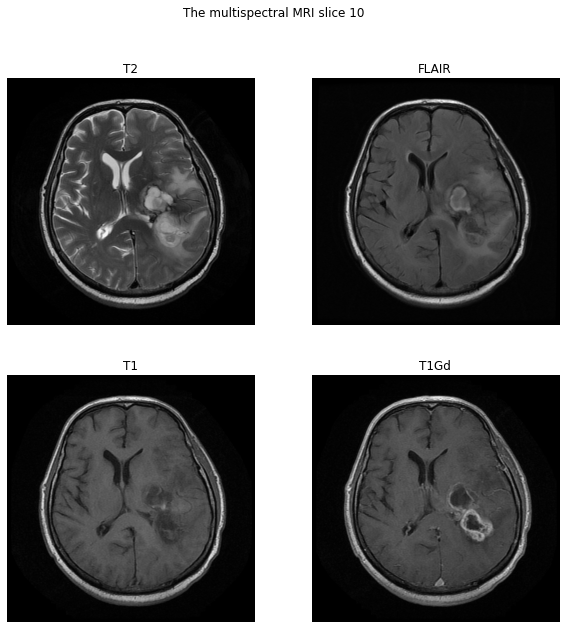

In [12]:
sl = 10
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, sl, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle('The multispectral MRI slice %d' % sl) 
plt.tight_layout
plt.show()

**Get the ROI mask data**

In [15]:
msk = img_roi.get_fdata()
mask = np.uint16(msk.squeeze())
mask.shape

(512, 512, 20)

**Display the multispectral MR image with the superimposed ROI mask for different slices**

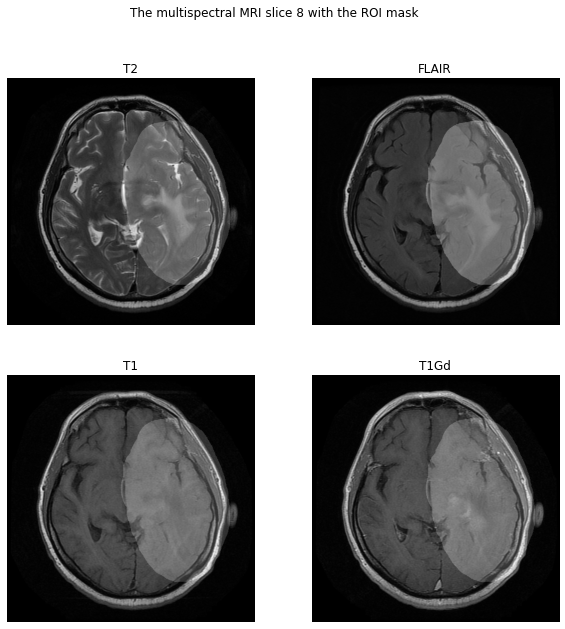

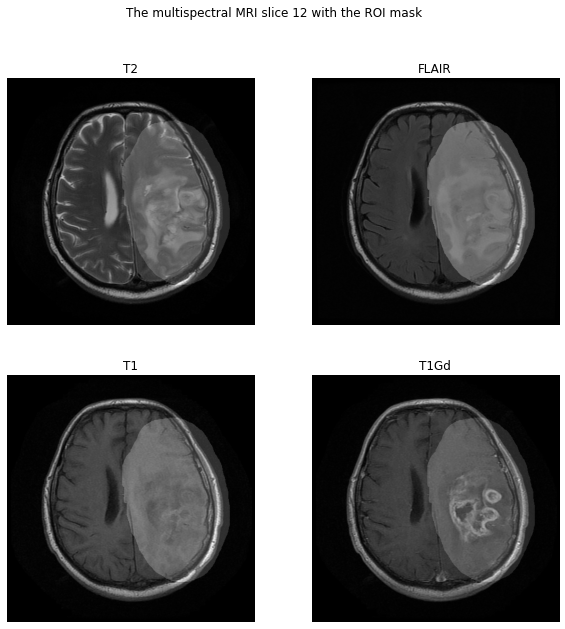

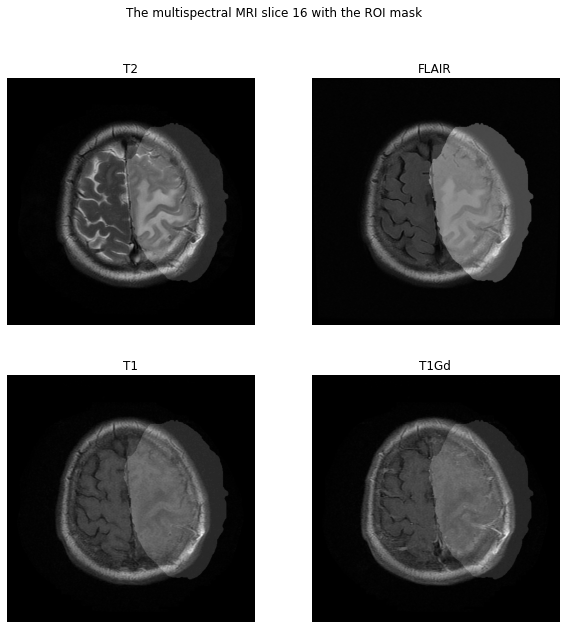

In [40]:
sl = 8
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, sl, k].T + 300*mask[:,:,sl].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle('The multispectral MRI slice %d with the ROI mask' % sl) 
plt.tight_layout
plt.show()

sl = 12
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, sl, k].T + 300*mask[:,:,sl].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle('The multispectral MRI slice %d with the ROI mask' % sl) 
plt.tight_layout
plt.show()

sl = 16
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(data[:, :, sl, k].T + 300*mask[:,:,sl].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle('The multispectral MRI slice %d with the ROI mask' % sl) 
plt.tight_layout
plt.show()


### Constructing a Pandas data frame from the MRI data (img_mult) and the ROI mask (img_roi)

Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfT)

In [45]:
# Find pixel locations (ind_roi) corresponding to tumor ROI (value 1 inside ROI, 0 else) 
ind_roi = np.where(mask == 1) 
X = np.asarray(data[ind_roi[0][:],ind_roi[1][:],ind_roi[2][:],:]) # The multispectral signal intensities
X.shape

(962086, 4)

In [46]:
ind_roi

(array([234, 234, 234, ..., 460, 460, 460]),
 array([289, 290, 291, ..., 240, 240, 240]),
 array([ 9,  9,  9, ...,  9, 10, 11]))

**Construct the multimodal "tumor" data frame, dfT**

In [47]:
dfT = pd.DataFrame(X, columns = chn_names)

# Add the voxel coordinates
dfT.insert(loc = len(dfT.columns),
           column = 'row',
           value = ind_roi[0])  # Row of pixel location
dfT.insert(loc = len(dfT.columns),
           column = 'col',
           value = ind_roi[1])  # Col of pixel location
dfT.insert(loc = len(dfT.columns),
           column = 'sli',
           value = ind_roi[2])  # Slice of pixel location

In [49]:
dfT.head()

,T2,FLAIR,T1,T1Gd,row,col,sli
0,296,269,559,578,234,289,9
1,313,269,554,570,234,290,9
2,380,294,549,530,234,291,9
3,452,333,540,494,234,292,9
4,472,349,506,501,234,293,9


In [50]:
dfT.tail()

,T2,FLAIR,T1,T1Gd,row,col,sli
962081,16,16,36,43,460,239,10
962082,28,16,31,46,460,239,11
962083,21,16,23,49,460,240,9
962084,14,13,36,39,460,240,10
962085,26,12,24,33,460,240,11


**Find the min an max slice in the ROI**

In [55]:
print('ROI min slice and max slice:', dfT.sli.min(), ',', dfT.sli.max())

ROI min slice and max slice: 0 , 18


### OPTIONAL: Scaling* of feature vectors  (MRI signal inensity), channel-by-channel wthin the ROI mask

*) Scaling to zero mean and unit standard deviation

In [56]:
scaler = StandardScaler()  
scaler.fit(X.astype(float))

X_scaled = scaler.transform(X.astype(float))  

# Make data frame from scaled X_train og y_train to check scaling
dX_scaled = pd.DataFrame(X_scaled, columns=chn_names)
dy = pd.concat([dfT.row, dfT.col, dfT.sli], axis=1)
X_scaled = pd.concat([dX_scaled, dy], axis=1)
X_scaled.head()

,T2,FLAIR,T1,T1Gd,row,col,sli
0,-0.387614,0.280994,0.650839,0.515233,234,289,9
1,-0.315005,0.280994,0.626753,0.479153,234,290,9
2,-0.028841,0.475690,0.602667,0.298754,234,291,9
3,0.278679,0.779415,0.559312,0.136394,234,292,9
4,0.364101,0.904020,0.395526,0.167964,234,293,9


In [57]:
X_scaled.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
T2,962086.0,0.0000,1.0000,-1.6519,0.0096,5.9251
FLAIR,962086.0,-0.0000,1.0000,-1.8061,0.1252,6.9396
T1,962086.0,0.0000,1.0000,-2.0420,0.1258,6.4123
T1Gd,962086.0,0.0000,1.0000,-2.0870,0.0687,7.5914
row,962086.0,348.6257,52.7946,234.0000,348.0000,460.0000
col,962086.0,252.7923,83.5786,82.0000,253.0000,422.0000
sli,962086.0,8.3885,4.9299,0.0000,8.0000,18.0000


## Unsupervised classification of multispectral MRI using K-means

In [58]:
X.shape  # n x p data matrix, n=samples, p = feature vector dimension

(962086, 4)

> # Start your experiments here:
(Make a copy of the original notebook and name it<br> e.g. 
`my_03-mri-kmeans-brain-tumor.ipynb`)

### Clustering the 4D multispectral data within the ROI mask 
####  LATER: _play with different values of `K`, `max_iter` and `tol`_

In [59]:
K = 16  # Number of clusters
max_iter = 300 # Max number of iteration
tol = 0.0001 # Tolerance
kmeans_model = KMeans(n_clusters=K, random_state=42, max_iter=max_iter, tol=tol)
print(kmeans_model)

KMeans(n_clusters=16, random_state=42)


In [60]:
%%time
# Fit the K-means model to the data
kmeans_fit = kmeans_model.fit(X)

In [61]:
print(kmeans_fit.labels_)
print('First centroid in p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[14 14 14 ...  6  6  6]
First centroid i p-dimensional feature vector space:
 [411.18629189 328.24858614 675.02937453 843.13412678]


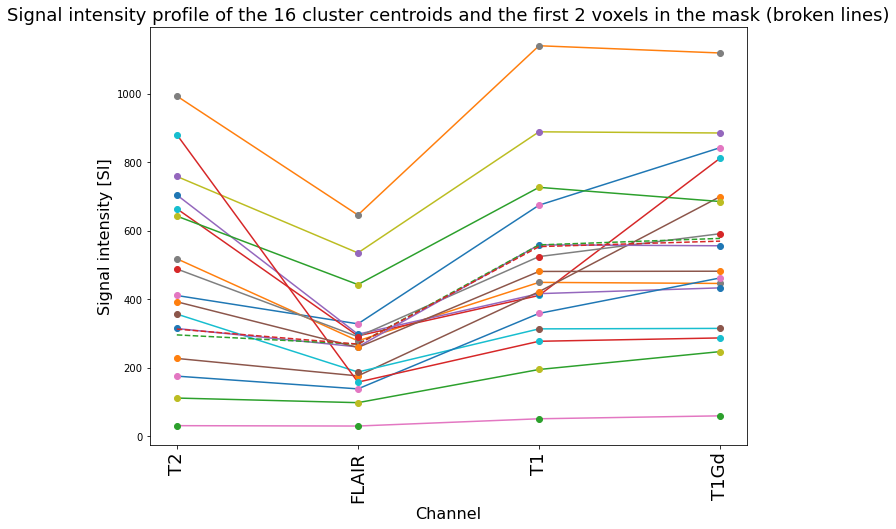

In [62]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, 'o')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(len(chn_names))])
ax.set_xticklabels(chn_names, rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Signal intensity profile of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**OPTIONAL:** Fit the K-means model to the scaled data

In [21]:
# Fit the K-means model to the scaled data
# kmeans_model_scaled = KMeans(n_clusters=K, random_state=42)
# kmeans_fit_scaled = kmeans_model_scaled.fit(X_scaled)

In [22]:
# print(kmeans_fit_scaled.labels_)
# print('First centroid in scaled p-dimensional feature vector space:\n', kmeans_fit_scaled.cluster_centers_[0,:])

#### Make a k-means segmented image (segmentation restricted to the ROI)

In [64]:
kmeans_segm = 0 * mask.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (512, 512, 20)
min: 0
max: 15
Number of clustered samples within ROI: 962086


#### Assign the cluster belonging to each voxel within the ROI

In [65]:
for v in range(len(ind_roi[0])):
    kmeans_segm[ind_roi[0][v], ind_roi[1][v], ind_roi[2][v]] = kmeans_fit.labels_[v]

**and dsiplay the result (comparing with the FLASH channel)**

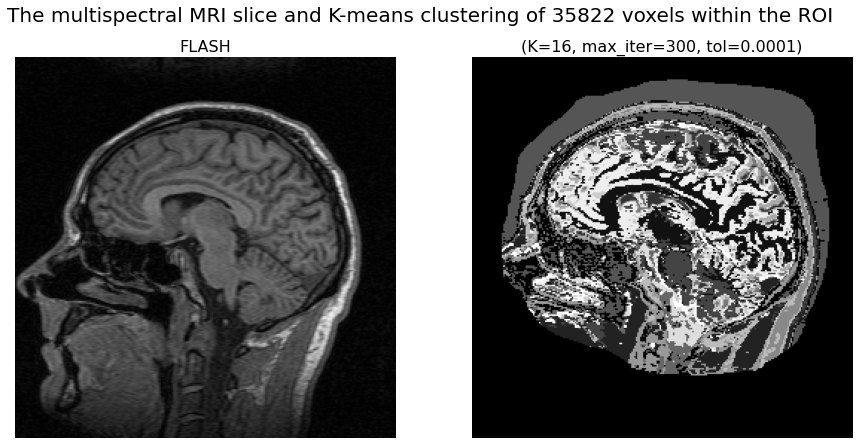

In [25]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0], fontsize=16)
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap='gray', origin='lower')
ax[1].set_title('(K=%d, max_iter=%d, tol=%.4f)' % (K, max_iter, tol), fontsize=16)
ax[1].axis('off')
plt.suptitle('The multispectral MRI slice and K-means clustering of %d voxels within the ROI' % (X.shape[0]), fontsize=20) 
plt.tight_layout
plt.show()

**Design a new [colormap](https://matplotlib.org/tutorials/colors/colormap-manipulation.html) for the clustering, using [named colors](https://matplotlib.org/examples/color/named_colors.html) and gray levels, a colorcode 
[dictionary](https://www.geeksforgeeks.org/python-dictionary)**

In [26]:
import matplotlib
col_code = {
    'CLU0': [255,255,255], # White (background)
    'CLU1': [255,0,255],   # Magenta 
    'CLU2': [255,0,0],     # Red 
    'CLU3': [0,255,255],   # Cyan 
    'CLU4': [0,0,255],     # Blue 
    'CLU5': [0,255,0],     # Green 
    'CLU6': [255,255,0],   # Yellow 
    'CLU7': [10,10,10],    # Gray levels
    'CLU8': [20,20,20],    
    'CLU10': [40,40,40],
    'CLU11': [80,80,80],     
    'CLU12': [120,120,120],     
    'CLU13': [150,150,150],        
    'CLU14': [180,180,180],  
    'CLU15': [200,200,200]  
}
clu_names = list(col_code.keys())
nclu = len(clu_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
clu_cmap = matplotlib.cm.get_cmap(mycmap, nclu)   # nclu discrete colors

In [27]:
clu_names_num = []
for i in range(nclu):
    str = clu_names[i] + ' [%d]' % (i)
    clu_names_num.append(str)

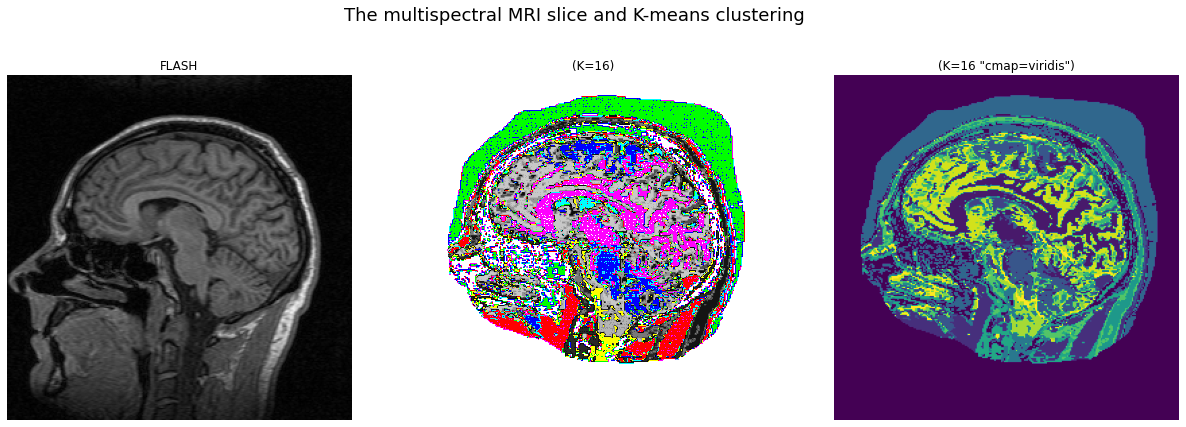

In [28]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
ax = axes.ravel()
ax[0].imshow(data[:, :, 0].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0])
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#ax[1].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
#cmsk = ax[1].imshow(kmeans_segm[:, :].T, cmap=clu_cmap, origin='lower')
#clim=cmsk.properties()['clim']
#cbar = fig.colorbar(cmsk, shrink=0.4, label='Cluster [0-%d]' % clim[1])
#cbar.ax.set_yticklabels(clu_names_num)
ax[1].set_title('(K=%d)' % (K))
ax[1].axis('off')
ax[2].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
ax[2].set_title('(K=%d "cmap=viridis")' % (K))
ax[2].axis('off')
plt.suptitle("The multispectral MRI slice and K-means clustering", fontsize=18) 
plt.tight_layout
plt.show()

### 3D scatterplot of clustered (color-coded) featurs vectors and the cluster centroids in 3D feature space

https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook <br>
Using the [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%matplotlib notebook` instead of `%matplotlib inline`

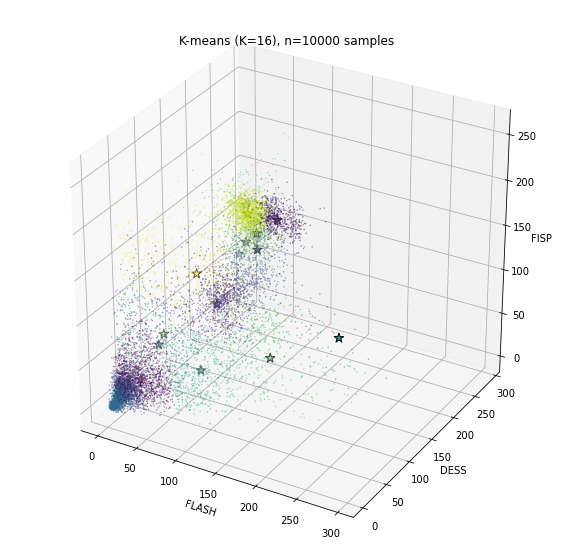

In [29]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

n=10000

xs = X[:n,0]
ys = X[:n,1]
zs = X[:n,2]
c = kmeans_fit.labels_[:n]

ax.scatter(xs, ys, zs, c=c, marker='.', s=0.5)

cxs = kmeans_fit.cluster_centers_[:,0]
cys = kmeans_fit.cluster_centers_[:,1]
czs = kmeans_fit.cluster_centers_[:,2]
cc = range(K)

ax.scatter(cxs, cys, czs, c=cc, marker='*', s=100,  edgecolors = 'black')


ax.set_xlabel('FLASH')
ax.set_ylabel('DESS')
ax.set_zlabel('FISP')

plt.title('K-means (K=%d), n=%d samples' % (K, len(xs)))
plt.show() 

## $\rightarrow$ Your turn!
> ## - Play with different values of `K`  (e.g. K=2, ...., 32)
> ## - Try to make biological (or MRI technical) interpretation of the clusters
> ## - Why does the K-means algorithm take longer to converge with increasing K ?
> ## - What does `random_state` do ?
> ## - Play with different values of `max_iter` and `tol` (explain your findings)
> ## - Try to formulate the k-means algorithm in the formalism of
## $$  y \approx f(\mathbf X, \theta) $$